In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 加载数据（假设文件在本地）
data = pd.read_csv('train.csv')
X = data.drop('label', axis=1).values  # 特征 (784维)
y = data['label'].values  # 标签 (0-9)

# 归一化（PCA对尺度敏感）
X = X / 255.0  # 像素值归一化到[0,1]

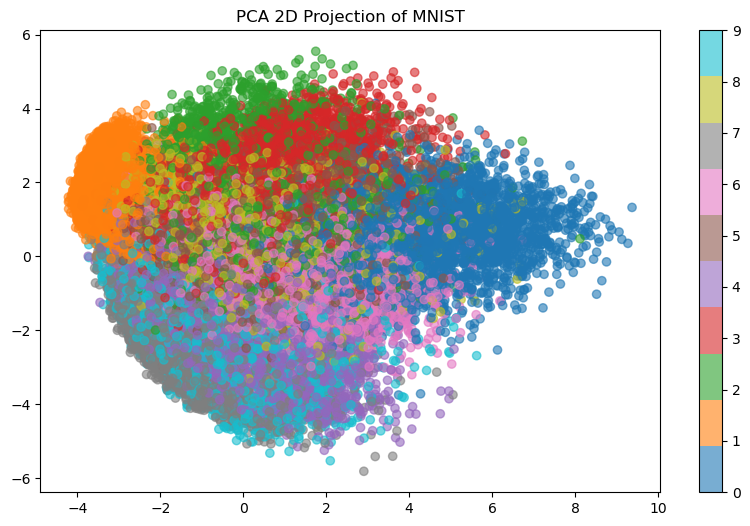

In [4]:
#PCA降维 （适合线性）
#PCA降维到2D和3D
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X)

pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X)

# 可视化2D结果
plt.figure(figsize=(10, 6))
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=y, cmap='tab10', alpha=0.6)
plt.colorbar()
plt.title('PCA 2D Projection of MNIST')
plt.show()
#PCA通过线性变换将数据投影到方差最大的方向（主成分）。
#n_components=2表示保留前两个主成分
#累计解释方差可通过pca_2d.explained_variance_ratio_查看。

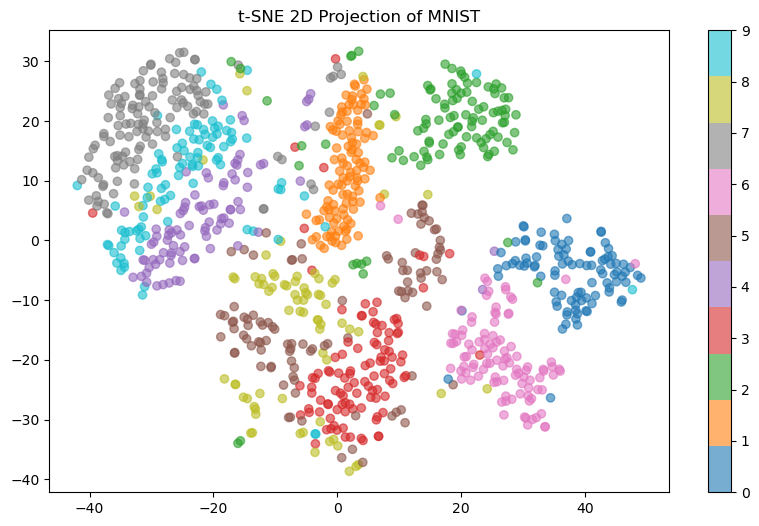

In [6]:
# t-SNE降维（非线性）
# t-SNE降维（耗时较长，建议先采样）
sample_idx = np.random.choice(len(X), 1000, replace=False)  # 随机采样1000个点
X_sample = X[sample_idx]
y_sample = y[sample_idx]

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_sample)

# 可视化
plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_sample, cmap='tab10', alpha=0.6)
plt.colorbar()
plt.title('t-SNE 2D Projection of MNIST')
plt.show()
#t-SNE是一种非线性降维方法，适合可视化高维数据的局部结构
#perplexity参数控制局部邻域大小（通常5-50）

#增强解释性——t-SNE可视化模型错误分类

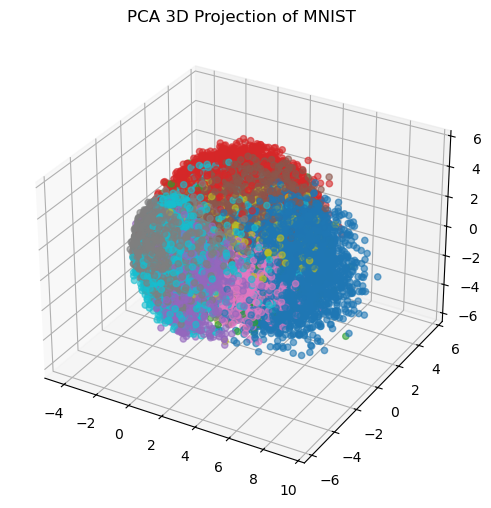

In [8]:
#3D可视化
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=y, cmap='tab10', alpha=0.6)
plt.title('PCA 3D Projection of MNIST')
plt.show()

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
#在数学建模中，遇到高维数据（如图像、问卷量表）时，直接使用原始特征会导致计算复杂度高且可能过拟合
#通过PCA压缩特征，可提升模型效率。

# 原始数据（784维）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# PCA保留95%方差
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
print("保留95%方差所需维度：", pca.n_components_)  # 输出可能为154维（远小于784）

# 训练随机森林
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)
print("PCA降维后准确率：", accuracy_score(y_test, y_pred))
# 对比不降维的结果（耗时更长！）
# clf.fit(X_train, y_train)
# y_pred_raw = clf.predict(X_test)
# print("原始数据准确率：", accuracy_score(y_test, y_pred_raw))

保留95%方差所需维度： 153
PCA降维后准确率： 0.9380952380952381


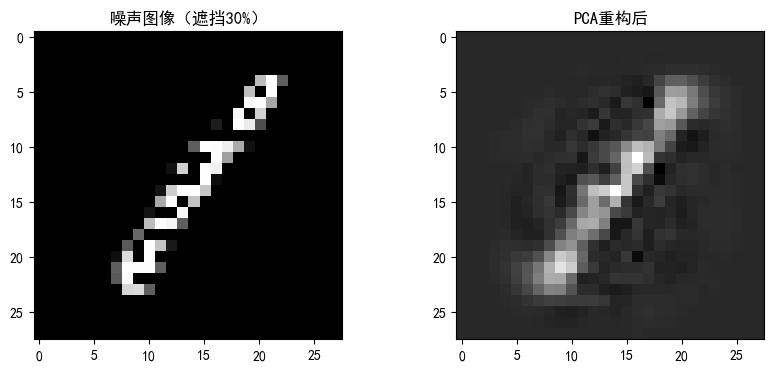

In [14]:
#去除噪声——PCA重构数据滤除干扰
# 人为添加噪声（模拟图像遮挡）
noise_mask = np.random.rand(*X.shape) < 0.3  # 30%像素被遮挡
X_noisy = X.copy()
X_noisy[noise_mask] = 0  # 被遮挡的像素置0

# PCA重构数据
pca = PCA(n_components=100)  # 保留前100个主成分
X_reconstructed = pca.inverse_transform(pca.fit_transform(X_noisy))

# 可视化对比
plt.rcParams['font.sans-serif'] = ['SimHei']#用中文
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(X_noisy[0].reshape(28, 28), cmap='gray')
plt.title("噪声图像（遮挡30%）")
plt.subplot(1, 2, 2)
plt.imshow(X_reconstructed[0].reshape(28, 28), cmap='gray')
plt.title("PCA重构后")
plt.show()

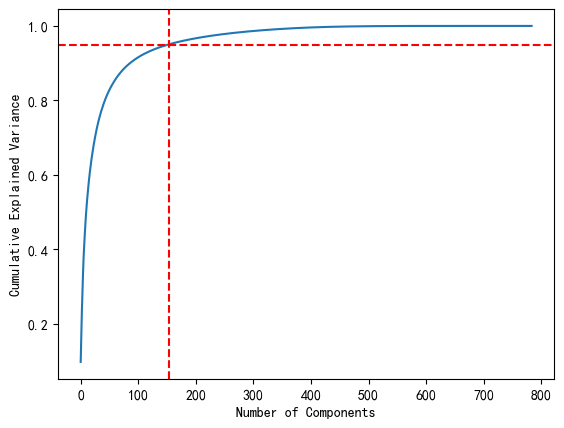

In [20]:
#用热力图展示PCA主成分与原始特征的关系（如主成分1主要由哪些像素决定）。

#用累积方差图说明PCA维度选择依据：
#论文要素：肘部点Elbow Point，解释方差比Explained Variance Ratio
pca_or = PCA().fit(X)  # X为归一化后的原始数据
plt.plot(np.cumsum(pca_or.explained_variance_ratio_))
plt.axhline(0.95, c='r', linestyle='--')
plt.axvline(154, c='r', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.savefig('cumulative_variance.png', dpi=300)